# LoC Data Package Tutorial: Selected Digitized Books Data Package

This notebook will demonstrate basic usage of using Python for interacting with [data packages from the Library of Congress](https://data.labs.loc.gov/packages/) via the [Selected Digitized Books Data Package](https://data.labs.loc.gov/digitized-books/) which is derived from the Library's [Selected Digitized Books collection](https://www.loc.gov/collections/selected-digitized-books/about-this-collection/). We will:

1. [Output a summary of the contents of this data package](#Output-data-package-summary)
2. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
3. [Download full text files and visualize it](#Download-full-text-files-and-visualize-it)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Output data package summary

First we will output a summary of the data package contents

In [1]:
import io

import pandas as pd                     # for reading, manipulating, and displaying data
import requests

from helpers import get_file_stats

DATA_URL = 'https://data.labs.loc.gov/digitized-books/' # Base URL of this data package

# Download the file manifest
file_manifest_url = f'{DATA_URL}manifest.json'
response = requests.get(file_manifest_url, timeout=60)
response_json = response.json()
files = [dict(zip(response_json["cols"], row)) for row in response_json["rows"]] # zip columns and rows

# Convert to Pandas DataFrame and show stats table
stats = get_file_stats(files)
pd.DataFrame(stats)

,FileType,Count,Size
0,.json,"83,083",32.33GB
1,.txt,"83,135",31.33GB


## Query the metadata in a data package

Next we will download a data package's metadata, print a summary of the items' subject values, then filter by a particular location.

All data packages have a metadata file in .json and .csv formats. Let's load the data package's `metadata.json` file:

In [5]:
metadata_url = f'{DATA_URL}metadata.json'
response = requests.get(metadata_url, timeout=60)
data = response.json().values()
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 90,414 entries.


Next let's convert to pandas DataFrame and print the available properties

In [6]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

access_restricted, aka, campaigns, contributor, date, dates, description, digitized, extract_timestamp, group, hassegments, id, image_url, index, item, language, mime_type, number, number_lccn, number_source_modified, online_format, original_format, other_title, partof, resources, segments, shelf_id, site, timestamp, title, url, number_oclc, type, subject, location, number_preceding_items, partof_title, publication_frequency, location_city, location_country, number_succeeding_items, number_former_id, number_issn, location_state, composite_location, number_carrier_type


Next print the top 10 most frequent subjects in this dataset

In [7]:
# Since "subject" fields are a list, we must "explode" it so there's just one subject per row
# We convert to DataFrame so it displays as a table
df['subject'].explode().value_counts().iloc[:10].to_frame()

,subject
history,9567
united states,9025
description and travel,3133
politics and government,2467
biography,1823
world war,1716
civil war,1514
poetry,1343
education,1109
grammar,928


Now we filter the results to only those items with subject "poetry"

In [9]:
df_by_subject = df.explode('subject')
poetry_subset = df_by_subject[df_by_subject.subject == 'poetry']
print(f'Found {poetry_subset.shape[0]:,} items with subject "poetry"')

Found 1,343 items with subject "poetry"


## Visualize text from this dataset

First let's filter the file manifest by file type.

In [10]:
# Convert file manifest to dataframe
df_files = pd.DataFrame(files)
# Filter to just text files
df_text_files = df_files[df_files['object_key'].str.endswith('.txt')]
print(f'Found {df_text_files.shape[0]:,} text files')

Found 83,135 text files


Next, we merge the poetry subset with the text files, so we just have the poetry text files.

In [13]:
poetry_with_text = pd.merge(df_text_files, poetry_subset, left_on='item_id', right_on='id', how='inner')
print(f'Found {poetry_with_text.shape[0]:,} poetry items with text files')

Found 1,290 poetry items with text files


Next we load the first 100 text files from the poetry subset

In [15]:
count = 100
poetry_subset = poetry_with_text.head(count).reset_index()
text = ''
for i, row in poetry_subset.iterrows():
    # Download the text
    file_url = f'https://{row["object_key"]}'
    response = requests.get(file_url, timeout=60)
    text += response.text
    text += '\n'
print(f"Loaded text with length {len(text):,} from {count} text files")

Loaded text with length 28,456,366 from 100 text files


And clean up the text by removing non-words

In [16]:
import re

whitespace_pattern = re.compile(r"\s+")
nonword_pattern = re.compile(r" [\S]*[\\\^<>]+[\S]* ")
tinyword_pattern = re.compile(r" [\S][\S]?[\S]? ")
text = text.replace('\\n', '')
text = whitespace_pattern.sub(" ", text).strip()
text = nonword_pattern.sub(" ", text)
text = tinyword_pattern.sub(" ", text)
text = whitespace_pattern.sub(" ", text).strip()
print(text[:100])

LIBRARY CONGRESS. ■ riiap. Capyright •Shelf.. P4t?. UNITED STATES AMERICA. ECLECTIC SCHOOL READINGS 


Finally generate a wordcloud using the text

(-0.5, 399.5, 199.5, -0.5)

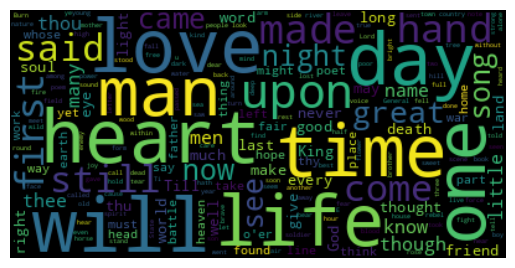

In [17]:
import matplotlib.pyplot as plt         # for displaying data
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")